<a href="https://colab.research.google.com/github/DhirajReddy/MachineLearning/blob/master/NYSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/mydrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/mydrive/


In [0]:
%matplotlib inline
import pandas as pd
import random
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import time

## __Data extracted is from New York stock exchange from the Kaggle challenge https://www.kaggle.com/dgawlik/nyse__

## __The concentration of this notebook is to predict the close prices of the stocks__

In [0]:
data = pd.read_csv('/content/mydrive/My Drive/nyse/prices-split-adjusted.csv')
data.date = data.date.astype(np.datetime64)
data.sort_values(by=['date'], inplace=True)
data.set_index('date', inplace = True)

In [5]:
data.head(5)

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,SYMC,18.040001,18.400000,18.01,18.530001,8322300.0
2010-01-04,IFF,41.509998,42.009998,41.50,42.020000,286000.0
2010-01-04,ILMN,31.120001,30.549999,30.42,31.230000,1793700.0
2010-01-04,INTC,20.790001,20.879999,20.73,21.030001,47800900.0
2010-01-04,INTU,31.090000,30.809999,30.77,31.150000,2353000.0


In [6]:
data.tail(5)

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ES,55.599998,55.230000,55.070000,55.740002,1446800.0
2016-12-30,EQT,65.699997,65.400002,65.050003,66.470001,1242100.0
2016-12-30,EQR,63.590000,64.360001,63.189999,64.440002,1534000.0
2016-12-30,EXR,75.669998,77.239998,75.110001,77.300003,884400.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [7]:
data.isnull().sum()

symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [8]:
  data.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


## __There are 501 unique stock prices__

In [9]:
data.symbol.describe()

count     851264
unique       501
top          BLL
freq        1762
Name: symbol, dtype: object

In [10]:
data.shape

(851264, 6)

In [0]:
all_symbols = data.symbol.unique().tolist()

## Get the closing price of each stock at the end of each year

In [0]:
growthData = pd.DataFrame(index=all_symbols, columns=['2010','2011','2012','2013','2014','2015','2016'])
for sym in all_symbols:
  symData = data[data.symbol == sym]['close']
  yearEndClosePrices = []
  for year in range(2010, 2017,1):
    closePrice = symData[symData.index.year == year]
    if closePrice.size > 0:
      yearEndClosePrices.append(float(symData[symData.index.year == year].tail(1)))
    else:
      yearEndClosePrices.append(np.nan)
        
  growthData.loc[sym] = yearEndClosePrices

In [67]:
growthData.head()
  

,2010,2011,2012,2013,2014,2015,2016
SYMC,16.74,15.65,18.82,23.58,25.66,21,23.89
IFF,55.59,52.42,66.54,85.98,101.36,119.64,117.83
ILMN,63.34,30.48,55.59,110.59,184.58,191.95,128.04
INTC,21.03,24.25,20.62,25.96,36.29,34.45,36.27
INTU,49.3,52.59,59.48,76.32,92.19,96.5,114.61


## Calculate the percentage change of each stock year on year

In [68]:
growthData_pct_change = growthData.pct_change(axis='columns')
growthData_pct_change.head()

,2010,2011,2012,2013,2014,2015,2016
SYMC,NaN,-0.065114,0.202556,0.252922,0.088210,-0.181606,0.137619
IFF,NaN,-0.057025,0.269363,0.292155,0.178879,0.180347,-0.015129
ILMN,NaN,-0.518787,0.823819,0.989387,0.669048,0.039928,-0.332951
INTC,NaN,0.153115,-0.149691,0.258972,0.397920,-0.050703,0.052830
INTU,NaN,0.066734,0.131014,0.283120,0.207940,0.046751,0.187668


## Each year the top 5 performing stocks

In [96]:
# Top performing symbols in each year with respect to their growth rate
for year in range(2011,2017,1):  
  year = str(year)
  print(f'=========={year}==========')
  print(' '*24)
  print(growthData_pct_change.sort_values(by=year, ascending=False).head()[year])
  print(' '*24)

==========2011==========
                        
COG     1.005284
ULTA    0.909412
ISRG    0.796353
ALXN    0.775295
MNST    0.762433
Name: 2011, dtype: float64
                        
==========2012==========
                        
REGN    2.086235
PHM     1.877971
AAL     1.662722
WHR     1.144362
EXPE    1.117161
Name: 2012, dtype: float64
                        
==========2013==========
                        
NFLX    2.976347
MU      2.430599
BBY     2.365401
ENDP    1.571864
DAL     1.314237
Name: 2013, dtype: float64
                        
==========2014==========
                        
SWKS    1.545868
LUV     1.246285
AAL     1.123960
EA      1.049695
EW      0.937044
Name: 2014, dtype: float64
                        
==========2015==========
                        
NFLX    1.343784
AMZN    1.177831
ATVI    0.921092
AYI     0.669165
NVDA    0.643890
Name: 2015, dtype: float64
                        
==========2016==========
                        
NVDA    2.23847

## Lets see the companies with highest revenue

In [0]:
fundementals = pd.read_csv('/content/mydrive/My Drive/nyse/fundamentals.csv')
securities = pd.read_csv('/content/mydrive/My Drive/nyse/securities.csv')

In [85]:
fundementals.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


## Walmart has the highest revenue

In [87]:
top_revenue = fundementals.groupby(by='Ticker Symbol').agg({'Total Revenue':sum})['Total Revenue'].nlargest(5)
top_revenue

Ticker Symbol
WMT     1.912726e+12
XOM     1.525938e+12
AAPL    8.030590e+11
CVX     7.811650e+11
GM      6.300920e+11
Name: Total Revenue, dtype: float64

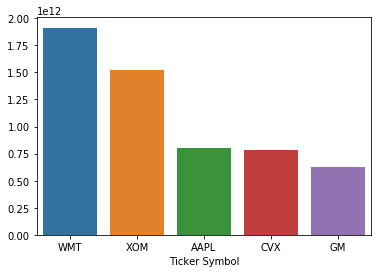

In [99]:
plt.figure()
names = securities[top_revenue.keys().tolist().contains(securities['Ticker symbol'].str)]
sns.barplot(x=top_revenue.keys(), y=top_revenue.values)
plt.show()

In [121]:
print(securities[securities['Ticker symbol'] == 'WMT'].Security)
print(securities[securities['Ticker symbol'] == 'XOM'].Security)
print(securities[securities['Ticker symbol'] == 'AAPL'].Security)
print(securities[securities['Ticker symbol'] == 'CVX'].Security)
print(securities[securities['Ticker symbol'] == 'GM'].Security)

478    Wal-Mart Stores
Name: Security, dtype: object
179    Exxon Mobil Corp.
Name: Security, dtype: object
45    Apple Inc.
Name: Security, dtype: object
98    Chevron Corp.
Name: Security, dtype: object
208    General Motors
Name: Security, dtype: object


In [0]:
def time_now():
    return time.time()

In [0]:
def GetCloseValues(symbol : str, df : pd.DataFrame) -> np.ndarray:
  """
  Get the close column of the data frame
  """
  closeValues : np.ndarray = np.array(df[df.symbol == symbol]['close'].tolist())
  return closeValues  

In [0]:
def SplitSequenceIntoTrainAndTest(trainPercentage : float, sequence : np.ndarray):
  """
  returns (train, test) split at trainPercentage
  """
  split_index = int(sequence.shape[0] * trainPercentage)
  train = sequence[0 : split_index]
  test = sequence[split_index : ]
  return (train, test)

In [0]:
def Scale(train, test):
  scaler = MinMaxScaler()
  train = scaler.fit_transform(train.reshape(train.size, -1))
  test = scaler.transform(test.reshape(test.size, -1))
  return scaler, train, test

In [0]:
def PrepareData(sequence : np.ndarray, n_steps : int):
  """
  We prepare the data in the format that LSTMs expect
  For example : for 2 time steps and for sequence [1,2,3,4,5,6,7]
  The x and y is
  [[1]
   [2]] [3]
  [[3]
   [4]] [5]
  [[5]
   [6]] [7]
   
   In every sample each column is feature, each row is a time step
  """
  x, y = [],[]
  length = sequence.shape[0]
  for i in range(length):
    end_index = i + n_steps
    
    if(end_index >= length):
      break;
     
    x.append(sequence[i:end_index]) 
    y.append(sequence[end_index])
    
  x = np.array(x)
  y = np.array(y)
  x = x.reshape(x.shape[0], n_steps, 1)
  return x, y 

In [0]:
def CreateModel(rate = 0.4, n_features = 501):
  model = Sequential()
  model.add(GRU(256, return_sequences=True, input_shape = (2, n_features)))
  model.add(Dropout(rate))
  model.add(LSTM(256))
  model.add(Dropout(rate))
  model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(n_features))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  return model

In [0]:
def MeanAbsolutePercentageError(y_true, y_pred): 
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def split_sequences(sequences, n_steps):
   """
  We prepare the data in the format that LSTMs expect
  For example : for 2 time steps and for sequences [1,2,3,4,5,6,7] and [10,20,30,40,50,60,70]
  The x and y is
  [[1 10]
   [2 20]] [3 30]
  [[3 30]
   [4 40]] [5 50]
  [[5 50]
   [6 60]] [7 70]
   
   In every sample each column is feature, each row is a time step
  """
  x, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    
    if(end_ix > len(sequences)-1):
      break
      
    seq_x, seq_y = sequences[i: end_ix, :], sequences[end_ix, :]
    
    x.append(seq_x)
    y.append(seq_y)
    
  x = np.array(x)
  y = np.array(y)
  
  return x, y

In [0]:
# 1792 is the maximum number of observations for most of the stocks
# In order to predict the stock prices using multiple series to gether in an LSTM, we need to Zeropad the unknown values
MAX_VALUES_TRAIN = 1409 # 1792 * 0.8
MAX_VALUES_TEST = 353 # 1792 - 1409
def ZeroPadding(sequence, maxPaddingWidth):
  """
  sequence = [1,2,3,4]
  return sequence = [1,2,3,4,0,0,0,.... upto 1791 index]
  
  sequence = [1,2,3,4, 5, 6, 7 .... 1791]
  return sequence = [1,2,3,4, 5, 6, 7..... 1791] -> No padding as the length match
  """
  length = len(sequence)
  if(length < maxPaddingWidth):
    retVal = np.pad(sequence.flatten(), (0, maxPaddingWidth-length), 'constant', constant_values=[0])
    return retVal
  return sequence

In [0]:
def ParallelSequencesTrainTestSplit(multiParallelSeries, n_steps, split_ratio):
  """
  multiparallelSeries : list of arrays [np.array([1,2,3...]), np.array([10,20,30...]), .....]
  n_steps : number of time steps.
  Each parallel sequence is split in to 80% train and 20% test data.
  The train and test data are prepared for LSTM in the below format
   [[1 10]
   [2 20]] [3 30]
  [[3 30]
   [4 40]] [5 50]
  [[5 50]
   [6 60]] [7 70]
   
   Each sample has 2 coulmns, each column for a time series and each row is the time step.
  """
  if(len(multiParallelSeries) < 2):
    return SplitSequenceIntoTrainAndTest(split_ratio, multiParallelSeries[0])
  
  scalers = []
  
  train1, test1 = SplitSequenceIntoTrainAndTest(split_ratio, multiParallelSeries[0])
  scaler1, train1, test1 = Scale(train1, test1)
  train1 = ZeroPadding(train1, MAX_VALUES_TRAIN)
  test1 = ZeroPadding(test1, MAX_VALUES_TEST)
  scalers.append(scaler1)
  
  train2, test2 = SplitSequenceIntoTrainAndTest(split_ratio, multiParallelSeries[1])
  scaler2, train2, test2 = Scale(train2, test2)
  train2 = ZeroPadding(train2, MAX_VALUES_TRAIN)
  test2 = ZeroPadding(test2, MAX_VALUES_TEST)
  scalers.append(scaler2)
  
  train_parallel_sequences = np.hstack((train1.reshape(MAX_VALUES_TRAIN, -1), train2.reshape(MAX_VALUES_TRAIN, -1)))
  test_parallel_sequences = np.hstack((test1.reshape(MAX_VALUES_TEST, -1), test2.reshape(MAX_VALUES_TEST, -1)))
  
  for series in multiParallelSeries[2:]:
    train, test = SplitSequenceIntoTrainAndTest(split_ratio, series)
    scaler, train, test = Scale(train, test)
    train = ZeroPadding(train, MAX_VALUES_TRAIN)
    test = ZeroPadding(test, MAX_VALUES_TEST)
    scalers.append(scaler)
    
    train_parallel_sequences = np.hstack((train_parallel_sequences, train.reshape(MAX_VALUES_TRAIN, -1)))
    test_parallel_sequences = np.hstack((test_parallel_sequences, test.reshape(MAX_VALUES_TEST, -1)))
  
  train_parallel_sequences_x, train_parallel_sequences_y = split_sequences(train_parallel_sequences, n_steps)
  test_parallel_sequences_x, test_parallel_sequences_y = split_sequences(test_parallel_sequences, n_steps)
  
  return scalers, train_parallel_sequences_x, train_parallel_sequences_y, test_parallel_sequences_x, test_parallel_sequences_y

In [0]:
def TimeTaken(msg, time_tracker):
  print(f'{msg}')
  print(f'Time taken {int(time_now() - time_tracker)} seconds')

In [0]:
def Start(all_symbols, epochs):
  print(f'length of all symbols {len(all_symbols)}')

  multiParallelSeries = []
  time_tracker = time_now()
  
  for index, symbol in enumerate(all_symbols):
    sequence = GetCloseValues(symbol, data)
    multiParallelSeries.append(sequence)
    
  TimeTaken('Converted list of all stocks into a multi parallel series, where each series is represented by a symbol', time_tracker)
  
  time_tracker = time_now()
  scalers, train_x, train_y, test_x, test_y = ParallelSequencesTrainTestSplit(multiParallelSeries, 2, 0.8)
  TimeTaken('prepare and split parallel series in to train and test data', time_tracker)
  
  print('Create keras regressor')
  model = KerasRegressor(build_fn=CreateModel,verbose = 0)

  print('Constructing params dictionary')
  params = {'epochs' : epochs,
          'batch_size' : [150],
          'n_features' : [test_y.shape[1]],
          'rate': [0.3],
          'validation_data' : [(test_x, test_y)]}

  print('Initialize GridSearch')
  regressor = GridSearchCV(estimator = model, param_grid = params, n_jobs = 1, refit=True, scoring='neg_mean_squared_error')

  time_tracker = time_now()
  print('Training start...')
  regressor.fit(train_x, train_y)
  TimeTaken('Training end...', time_tracker)
  
  time_tracker = time_now()
  print('prediction start...')
  preds = regressor.predict(test_x)
  TimeTaken('prediction end...', time_tracker)
  
  time_tracker = time_now()
  print('plotting start...')
  
  errors = {}
  y_trues = []
  y_preds = []
  for i in range(test_y.shape[1]):
    indices_to_consider = np.where(test_y[:, i] != 0)
    y_true = test_y[:, i][indices_to_consider]
    y_pred = preds[:, i][indices_to_consider]
    scaler = scalers[i]
    y_true = scaler.inverse_transform(np.array(y_true).reshape(len(y_true), -1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(len(y_pred), -1)).flatten()
    y_trues.append(y_true)
    y_preds.append(y_pred)
    
    symbol = all_symbols[i]
    error = MeanAbsolutePercentageError(y_true, y_pred)
    errors[symbol] = error
    print(f'Mean absolute percentage error for symbol {symbol} is {error}%')

    plt.figure(i+1)
    plt.plot(y_pred, label = 'predictions')
    plt.plot(y_true, label = 'actual')
    plt.title(f'Closing prices of {symbol}')
    plt.legend()
  
  TimeTaken('plotting end...', time_tracker)
  
  return errors, y_trues, y_preds, regressor

length of all symbols 10
Converted list of all stocks into a multi parallel series, where each series is represented by a symbol
Time taken 0 seconds
prepare and split parallel series in to train and test data
Time taken 0 seconds
Create keras regressor
Constructing params dictionary
Initialize GridSearch
Training start...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Training end...
Time taken 245 seconds
prediction start...
prediction end...
Time taken 2 seconds
plotting start...
Mean absolute percentage error for symbol SYMC is 3.2380136790894527%
Mean absolute percentage error for symbol IFF is 4.3783507990169985%
Mean absolute percentage error for symbol ILMN is 13.47956006803432%
Mean absolute percentage error for symbol INTC is 1.7016032575793845%
Mean absolute percentage error for symbol INTU is 2.928952916569166%
Mean absolute percentage error for symbol IP is 13.363214165373527%
Mean absolute percentage error for symbol IPG is 3.7376239518269654%
Mean absolute percentage error for symbol IR is 3.804109759906657%
Mean absolute percentage error for symbol IRM is 3.772075034580079%
Mean absolute percentage error for symbol IDXX is 6.938798161291598%
plotting end...
Time taken 248 seconds


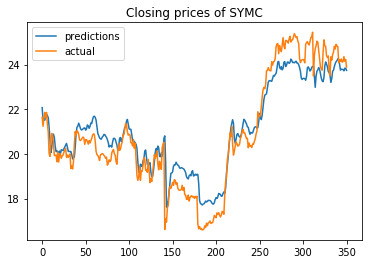

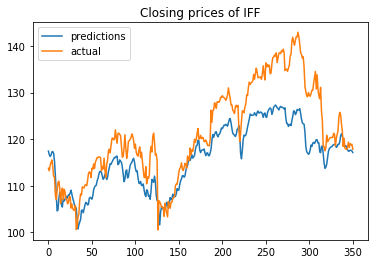

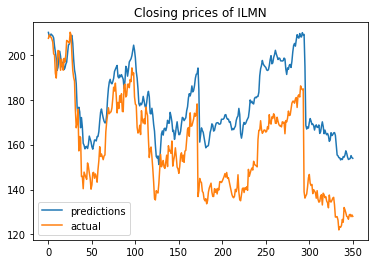

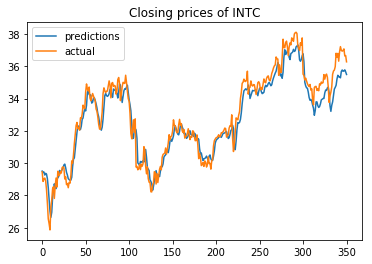

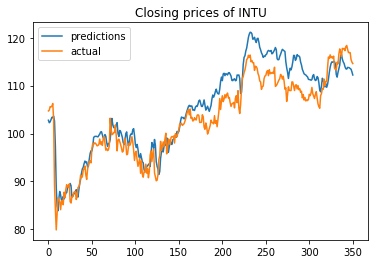

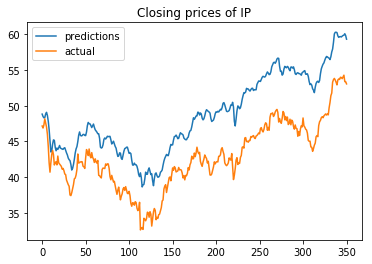

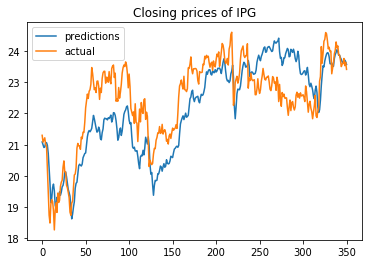

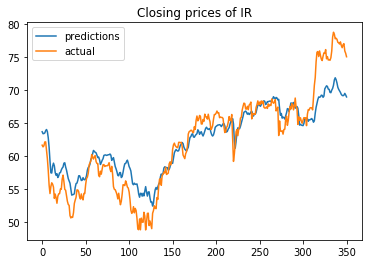

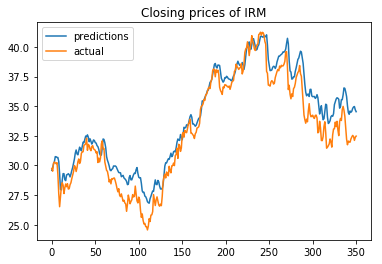

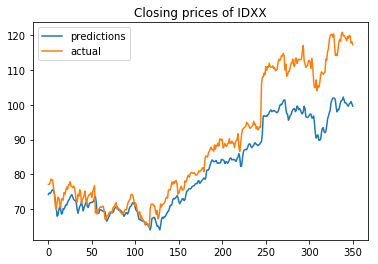

In [44]:
errors, y_trues, y_preds, regressor = Start(all_symbols[0:10], [100])

## It is evident that upon trying to solve for all the stock prices using a single architecture leads to a higher error percentage. There for we have to hyperparameter tune the architecture, epochs and batch size for each symbol. 

length of all symbols 2
Converted list of all stocks into a multi parallel series, where each series is represented by a symbol
Time taken 0 seconds
prepare and split parallel series in to train and test data
Time taken 0 seconds
Create keras regressor
Constructing params dictionary
Initialize GridSearch
Training start...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Training end...
Time taken 680 seconds
prediction start...
prediction end...
Time taken 3 seconds
plotting start...
Mean absolute percentage error for symbol IP is 5.685462330559029%
Mean absolute percentage error for symbol IDXX is 4.002368443573757%
plotting end...
Time taken 0 seconds


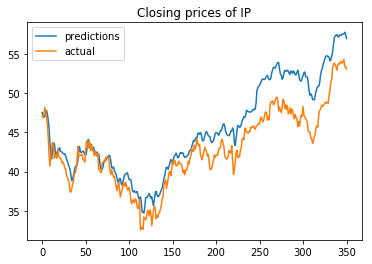

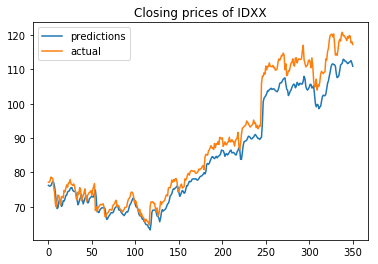

In [47]:
errors, y_trues, y_preds, regressor = Start(['IP','IDXX'], [100,120,140])

## As it can be observed the MAPE of IP and IDXX were 13.3% and 6.9% respectively when solved inconjuction with other stocks, but when sovled individuals and by tuning for the best number of epochs the error was reduced to 5% and 4% respectively.

length of all symbols 6
Converted list of all stocks into a multi parallel series, where each series is represented by a symbol
Time taken 0 seconds
prepare and split parallel series in to train and test data
Time taken 0 seconds
Create keras regressor
Constructing params dictionary
Initialize GridSearch
Training start...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Training end...
Time taken 765 seconds
prediction start...
prediction end...
Time taken 5 seconds
plotting start...
Mean absolute percentage error for symbol ADBE is 2.5392032612698276%
Mean absolute percentage error for symbol FB is 27.459931660732085%
Mean absolute percentage error for symbol GS is 7.871577697449789%
Mean absolute percentage error for symbol MSFT is 1.6752545045489535%
Mean absolute percentage error for symbol XRX is 5.119204871545972%
Mean absolute percentage error for symbol YHOO is 3.839332095289838%
plotting end...
Time taken 0 seconds
The end
Time taken 770 seconds


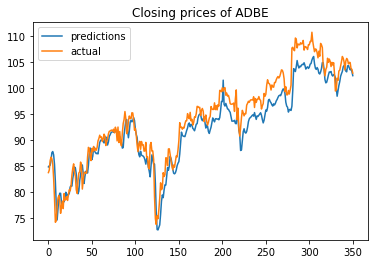

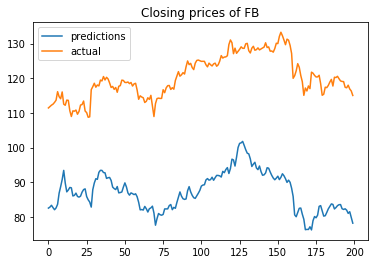

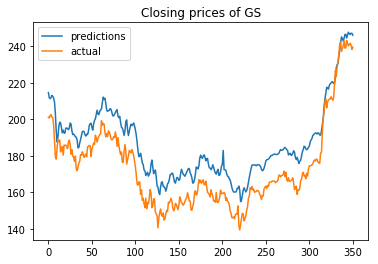

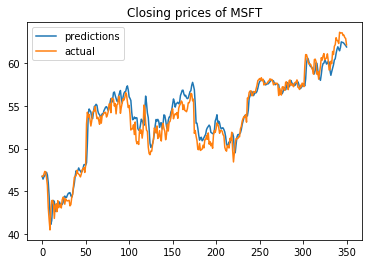

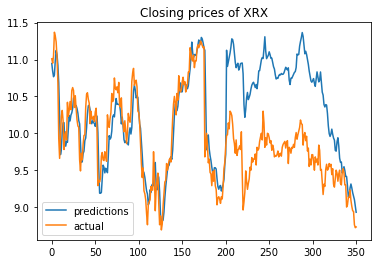

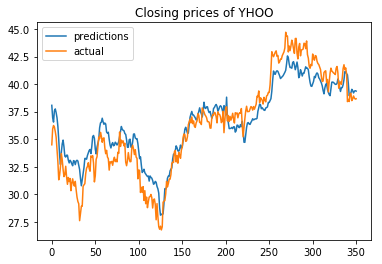

In [48]:
# Adobe, Facebook, Gold man sacs, microsoft, xerox, yahoo
time_tracker = time_now()
errors, y_trues, y_preds, regressor = Start(['ADBE','FB','GS','MSFT','XRX','YHOO'], [100,120,140])
TimeTaken("The end", time_tracker)

## We have to tune for FB and GS stocks as their error percentages are higher.. and so on

## Results/Error percentage for each stock

MAPE for symbol __SYMC__ is 3.238% <br>
MAPE for symbol __IFF__ is  4.378% <br>
MAPE for symbol __ILMN__ is 13.479% <br>
MAPE for symbol __INTC__ is 1.701% <br>
MAPE for symbol __INTU__ is 2.928% <br>
MAPE for symbol __IP__ is 5.685% <br>
MAPE for symbol __IDXX__ is 4.002% <br>
MAPE for symbol __IPG__ is 3.737% <br>
MAPE for symbol __IR__ is 3.804% <br>
MAPE for symbol __IRM__ is 3.772% <br>
MAPE for symbol __ADBE__ is 2.539% <br>
MAPE for symbol __FB__ is 27.459% <br>
MAPE for symbol __GS__ is 7.871% <br>
MAPE for symbol __MSFT__ is 1.675% <br>
MAPE for symbol __XRX__ is 5.119% <br>
MAPE for symbol __YHOO__ is 3.839% <br>


## Step by Step procedure



1. Check for empty entries, there were none
1. Check the uniquie number of stocks, there were 501
1. Check if all the stocks have the same number of observations, there are varying number of observations
1. Get the maximum number of observations for a stock, it is 1792
1. Split each stock into train and test data in the ration of 0.8 : 0.2
1. Scale the train data and the test data, i.e. perform Standardization
1. Treat each stock close prices as a time series data and pad each series to make each series length equal to 1792
1. Prepare multiple series data format to pass to an LSTM
1. Hyperparameter tune the number of epochs for different combinations of multi series data set
1. Plot the predicted and actual series
1. Print the mean absolute percentage error
1. For series with unacceptable MAPE, hyper parameter tune the epochs and architecture only for those stocks
